In [51]:
import math
import pandas as pd

from statsbombpy import sb
from mplsoccer import VerticalPitch

# First let's download our data
df = sb.events(match_id=3869685)

df[['x', 'y']] = df['location'].apply(pd.Series)

df = df[df['team'] == 'Argentina']

In [55]:
"""
I don't show this in the actual video, but this is how you would get a dataframe of all the jersey numbers for each player in the match.
This can differ in how you do this depending on the data provider

For statsbomb, they store it in the 'tactics' column of the event dataframe. This is a dictionary with a key 'lineup' which contains a list of players and their jersey numbers.

With whoscored data for example, they have the jersey number stored in a different dictionary in the matchCentre data
"""
tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

all_jersey_numbers = []
for y in tactics.to_dict(orient='records'):
    all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
    
jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()


"""
And then you would use this code to plot the player numbers at the very end
"""
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(
        jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
        xy=(row.x, row.y),
        c='#132743',
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax
    )

In [61]:
# Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60 * df["minute"] + df["second"]

df.sort_values(by=['newsecond'])

# identify the passer and then the recipient, who'll be the playerId of the next action
df['passer'] = df['player_id']

df['recipient'] = df['passer'].shift(-1)

# filter for only passes and then successful passes
passes_df = df.loc[(df['type']=="Pass")]
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]

#find time of the team's first substitution and filter the df to only passes before that
sub_df = df.loc[(df['type'] == "Substitution")]
first_sub = sub_df["newsecond"].min()

if first_sub <= (60 * 45):
    first_sub = 60 * 45

completions = completions.loc[completions['newsecond'] < first_sub]

# Find Average Locations
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# find number of passes along each 'path' of passer to recipient
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

/var/folders/l3/wlgnl3zd5hl46kfjq1yh3k9r0000gn/T/ipykernel_78589/3274327579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


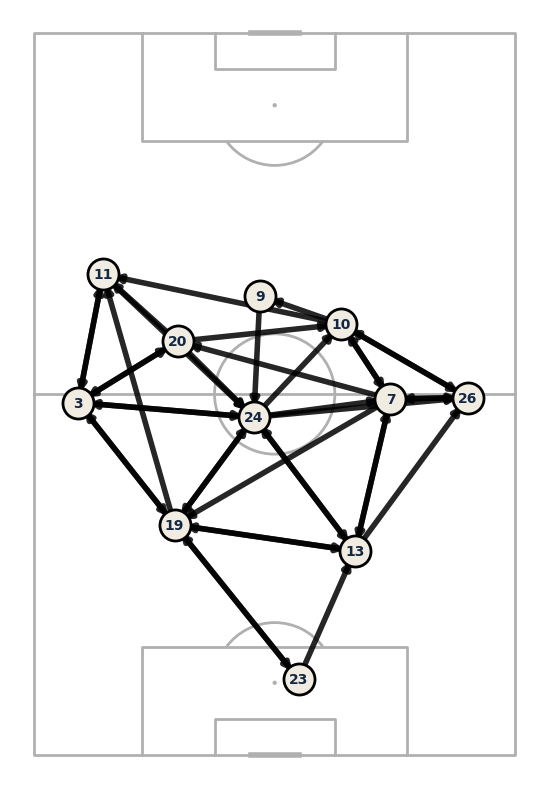

In [62]:

# plot arrows
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate(
        '',
        xy=(end_y,  end_x),
        xytext=(y, x),
        zorder=1,
        arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
    )
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)

pitch = VerticalPitch(pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(12, 8))

for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')

# plot nodes
pitch.scatter(
    average_locs_and_count.x, average_locs_and_count.y, s=500,
    color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
)
